# Préliminaire

In [136]:
import pandas as pd
import re
pd.set_option('display.max_columns', None)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [137]:
df = pd.read_csv('regularite-mensuelle-tgv-aqst.csv',delimiter=';')
df = df[df["duree_moyenne"] > 0] #73 lignes n'obéissent pas à cette condition

In [138]:
#Utils
def select_test_data(data):
    data['date'] = data['date'].str.strip()  # Remove leading/trailing spaces if any

    # Define the regular expression pattern
    pattern = re.compile(r'^2023-\d{2}$', re.IGNORECASE)

    # Filter rows with the desired date format
    test_data = data[data['date'].str.contains(pattern, na=False)]
    return test_data

def select_train_data(data,test_data):
    # Find the indices of rows in 'data' that are not in 'test_data'
    indices_to_keep = ~data.index.isin(test_data.index)

    # Create the 'train_data' DataFrame by selecting rows from 'data' using the indices to keep
    train_data = data[indices_to_keep].reset_index(drop=True)
    return train_data


# Splitting data into features and labels
def split_data(df, drop_columns):
	X = df.drop(columns = drop_columns + ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',\
			'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs'])
	y = df[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',\
			'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]

	return X, y

#Sppliting 'date' and O-H encoding
def date_service_proccess(train_data, test_data):
    df = pd.concat([train_data, test_data], axis=0)
    df[['année', 'mois']] = df['date'].str.split('-', expand=True) 
    df = df.drop(columns =['date', 'année'])

    df = pd.get_dummies(df, columns=['service', 'gare_depart', 'gare_arrivee'], dtype=int)

    train_data_encoded = df[:len(train_data)]
    test_data_encoded = df[len(train_data):]
    return train_data_encoded, test_data_encoded

# Niveau de réstriction & Séparation des données train/test

Niveaux de restriction: <br>
	1- Enlever l’autre colonne retard (retard_moyen_tous_trains_arrivee) <br>
	2- + Enlever les colonnes: nb_train_retard_sup15 , retard_moyen_trains_retard_sup_15 , nb_train_retard_sup_30 , nb_train_retard_sup_60 <br>
	3- + Enlever les colonnes: nb_train_retard_arrivee <br>
	4- + Enlever les colonnes: nb_train_retard_depart , retard_moyen_depart , retard_moyen_tous_trains_depart <br>
	5- + Enlever les colonnes: nb_annulation <br>

In [139]:
remove_columns_0 = ['commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee']
remove_columns_1 = remove_columns_0 + ['retard_moyen_tous_trains_arrivee']
remove_columns_2 = remove_columns_1 + ['nb_train_retard_sup_15' , 'retard_moyen_trains_retard_sup15' , 'nb_train_retard_sup_30' , 'nb_train_retard_sup_60']
remove_columns_3 = remove_columns_2 + ['nb_train_retard_arrivee']
remove_columns_4 = remove_columns_3 + ['nb_train_depart_retard' , 'retard_moyen_depart' , 'retard_moyen_tous_trains_depart']
remove_columns_5 = remove_columns_4 + ['nb_annulation']

In [140]:
remove_columns = remove_columns_0

In [141]:
#the test data before preprocessing
test_data=select_test_data(df)
test_data.head()

# The training data before preprocessing
train_data = select_train_data(df, test_data)
train_data.head()

train_data_encoded, test_data_encoded = date_service_proccess(train_data, test_data)

X_train, y_train = split_data(train_data_encoded, remove_columns)
X_test, y_test = split_data(test_data_encoded, remove_columns)

In [142]:
X_train

,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,mois,service_International,service_National,gare_depart_AIX EN PROVENCE TGV,gare_depart_ANGERS SAINT LAUD,gare_depart_ANGOULEME,gare_depart_ANNECY,gare_depart_ARRAS,gare_depart_AVIGNON TGV,gare_depart_BARCELONA,gare_depart_BELLEGARDE (AIN),gare_depart_BESANCON FRANCHE COMTE TGV,gare_depart_BORDEAUX ST JEAN,gare_depart_BREST,gare_depart_CHAMBERY CHALLES LES EAUX,gare_depart_DIJON VILLE,gare_depart_DOUAI,gare_depart_DUNKERQUE,gare_depart_FRANCFORT,gare_depart_GENEVE,gare_depart_GRENOBLE,gare_depart_ITALIE,gare_depart_LA ROCHELLE VILLE,gare_depart_LAUSANNE,gare_depart_LAVAL,gare_depart_LE CREUSOT MONTCEAU MONTCHANIN,gare_depart_LE MANS,gare_depart_LILLE,gare_depart_LYON PART DIEU,gare_depart_MACON LOCHE,gare_depart_MADRID,gare_depart_MARNE LA VALLEE,gare_depart_MARSEILLE ST CHARLES,gare_depart_METZ,gare_depart_MONTPELLIER,gare_depart_MULHOUSE VILLE,gare_depart_NANCY,gare_depart_NANTES,gare_depart_NICE VILLE,gare_depart_NIMES,gare_depart_PARIS EST,gare_depart_PARIS LYON,gare_depart_PARIS MONTPARNASSE,gare_depart_PARIS NORD,gare_depart_PARIS VAUGIRARD,gare_depart_PERPIGNAN,gare_depart_POITIERS,gare_depart_QUIMPER,gare_depart_REIMS,gare_depart_RENNES,gare_depart_SAINT ETIENNE CHATEAUCREUX,gare_depart_ST MALO,gare_depart_ST PIERRE DES CORPS,gare_depart_STRASBOURG,gare_depart_STUTTGART,gare_depart_TOULON,gare_depart_TOULOUSE MATABIAU,gare_depart_TOURCOING,gare_depart_TOURS,gare_depart_VALENCE ALIXAN TGV,gare_depart_VANNES,gare_depart_ZURICH,gare_arrivee_AIX EN PROVENCE TGV,gare_arrivee_ANGERS SAINT LAUD,gare_arrivee_ANGOULEME,gare_arrivee_ANNECY,gare_arrivee_ARRAS,gare_arrivee_AVIGNON TGV,gare_arrivee_BARCELONA,gare_arrivee_BELLEGARDE (AIN),gare_arrivee_BESANCON FRANCHE COMTE TGV,gare_arrivee_BORDEAUX ST JEAN,gare_arrivee_BREST,gare_arrivee_CHAMBERY CHALLES LES EAUX,gare_arrivee_DIJON VILLE,gare_arrivee_DOUAI,gare_arrivee_DUNKERQUE,gare_arrivee_FRANCFORT,gare_arrivee_GENEVE,gare_arrivee_GRENOBLE,gare_arrivee_ITALIE,gare_arrivee_LA ROCHELLE VILLE,gare_arrivee_LAUSANNE,gare_arrivee_LAVAL,gare_arrivee_LE CREUSOT MONTCEAU MONTCHANIN,gare_arrivee_LE MANS,gare_arrivee_LILLE,gare_arrivee_LYON PART DIEU,gare_arrivee_MACON LOCHE,gare_arrivee_MADRID,gare_arrivee_MARNE LA VALLEE,gare_arrivee_MARSEILLE ST CHARLES,gare_arrivee_METZ,gare_arrivee_MONTPELLIER,gare_arrivee_MULHOUSE VILLE,gare_arrivee_NANCY,gare_arrivee_NANTES,gare_arrivee_NICE VILLE,gare_arrivee_NIMES,gare_arrivee_PARIS EST,gare_arrivee_PARIS LYON,gare_arrivee_PARIS MONTPARNASSE,gare_arrivee_PARIS NORD,gare_arrivee_PARIS VAUGIRARD,gare_arrivee_PERPIGNAN,gare_arrivee_POITIERS,gare_arrivee_QUIMPER,gare_arrivee_REIMS,gare_arrivee_RENNES,gare_arrivee_SAINT ETIENNE CHATEAUCREUX,gare_arrivee_ST MALO,gare_arrivee_ST PIERRE DES CORPS,gare_arrivee_STRASBOURG,gare_arrivee_STUTTGART,gare_arrivee_TOULON,gare_arrivee_TOULOUSE MATABIAU,gare_arrivee_TOURCOING,gare_arrivee_TOURS,gare_arrivee_VALENCE ALIXAN TGV,gare_arrivee_VANNES,gare_arrivee_ZURICH
0,141,870,5,289,11.247809,3.693179,147,28.436735,6.511118,110,6.511118,44,8,01,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,165,222,0,8,2.875000,0.095796,34,21.524020,5.696096,22,5.696096,5,0,01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,220,248,1,37,9.501351,1.003981,26,55.692308,7.578947,26,7.548387,17,7,01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [143]:
y_train

,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000
...,...,...,...,...,...,...
7350,23.076923,19.230769,23.076923,23.076923,7.692308,3.846154
7351,22.023810,18.452381,22.619048,24.404762,2.976190,9.523810
7352,50.000000,0.000000,10.000000,10.000000,10.000000,20.000000
7353,7.299270,2.919708,45.255474,24.087591,13.868613,6.569343


# Benchmark pour la prédiction des pourcentages
Les données étant difficilement exploitable pour la prédiction des pourcentages de cause de retard, notre benchmark est un modèle simple qui prédit tout le temps la valeur moyenne pour chaque cause (scalée pour que la somme soit égale à 100%).

In [144]:
def mean_percentage(df, percentage_column, weights=None):
    if weights is not None:
        return np.average(df[percentage_column], weights=weights)
    else:
        return np.average(df[percentage_column])

In [145]:
percentage_columns = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',\
			'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']

In [148]:
y_mean_weighted = [mean_percentage(y_train, column, weights=X_train["nb_train_retard_arrivee"]) for column in percentage_columns]
y_mean = [mean_percentage(y_train, column, weights=None) for column in percentage_columns]

sum_w = np.sum(y_mean_weighted)
sum = np.sum(y_mean)
y_mean_weighted = [i * (100/sum_w) for i in y_mean_weighted]
y_mean = [i * (100/sum_w) for i in y_mean]

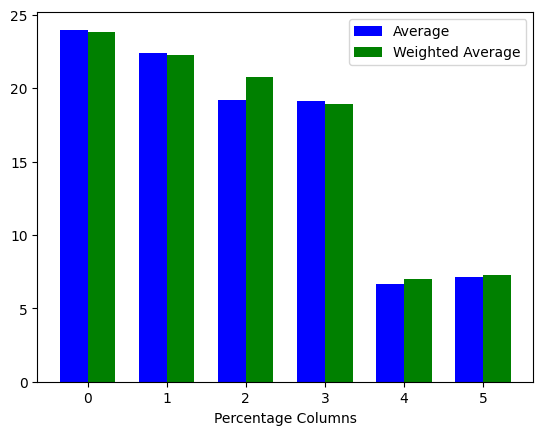

In [149]:
bar_width = 0.35

# Create the bar plot
plt.bar(np.arange(6), y_mean, width=bar_width, label='Average', color='blue')
plt.bar(np.arange(6) + bar_width, y_mean_weighted, width=bar_width, label='Weighted Average', color='Green')

# Set x-axis labels and title
plt.xlabel("Percentage Columns")
plt.xticks(np.arange(6) + bar_width / 2, range(6))

# Show a legend
plt.legend()

# Show the plot
plt.show()

In [150]:
y_test_pred_weighted = pd.DataFrame({percentage_columns[i] : [y_mean_weighted[i]] * y_test.shape[0] for i in range(6)})
y_test_pred =  pd.DataFrame({percentage_columns[i] : [y_mean[i]] * y_test.shape[0] for i in range(6)})

In [151]:
y_test_pred_weighted.head()

,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,23.826178,22.270661,20.756401,18.894177,6.992299,7.260283
1,23.826178,22.270661,20.756401,18.894177,6.992299,7.260283
2,23.826178,22.270661,20.756401,18.894177,6.992299,7.260283
3,23.826178,22.270661,20.756401,18.894177,6.992299,7.260283
4,23.826178,22.270661,20.756401,18.894177,6.992299,7.260283


In [152]:
RMSE_mean = [np.sqrt(mean_squared_error(y_test_pred[column], y_test.reset_index(drop=True)[column])) for column in percentage_columns]
RMSE_mean_weighted = [np.sqrt(mean_squared_error(y_test_pred_weighted[column], y_test.reset_index(drop=True)[column])) for column in percentage_columns]
MAE_mean = [mean_absolute_error(y_test_pred[column], y_test.reset_index(drop=True)[column]) for column in percentage_columns]
MAE_mean_weighted = [mean_absolute_error(y_test_pred_weighted[column], y_test.reset_index(drop=True)[column]) for column in percentage_columns]

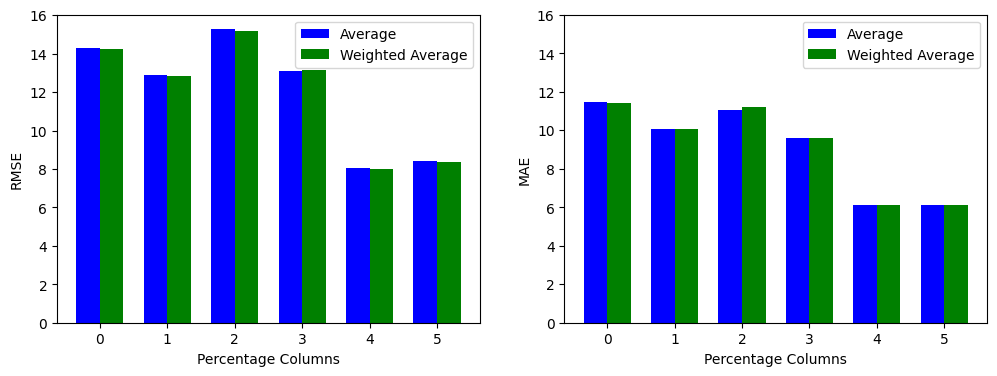

In [153]:
bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# RMSE
# Create the bar plot
ax1.bar(np.arange(6), RMSE_mean, width=bar_width, label='Average', color='blue')
ax1.bar(np.arange(6) + bar_width, RMSE_mean_weighted, width=bar_width, label='Weighted Average', color='Green')

# Set x-axis labels and title
ax1.set_xlabel("Percentage Columns")
ax1.set_ylabel("RMSE")
ax1.set_xticks(np.arange(6) + bar_width / 2)
ax1.set_xticklabels(range(6))

# Show a legend
ax1.legend()


# MAE
# Create the bar plot
ax2.bar(np.arange(6), MAE_mean, width=bar_width, label='Average', color='blue')
ax2.bar(np.arange(6) + bar_width, MAE_mean_weighted, width=bar_width, label='Weighted Average', color='Green')

# Set x-axis labels and title
ax2.set_xlabel("Percentage Columns")
ax2.set_ylabel("MAE")
ax2.set_xticks(np.arange(6) + bar_width / 2)
ax2.set_xticklabels(range(6))
ax2.set_ylim(top=16)

# Show a legend
ax2.legend()

# Show the plot
plt.show()

Même performance pour les moyennes et les moyennes pondérées.

In [157]:
y_test_pred - y_test.reset_index(drop=True)

,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,17.733825,19.303434,-15.177686,-2.733417,-15.210413,-5.394637
1,8.983825,7.428434,-15.802686,4.141583,1.664587,-7.894637
2,-2.827769,-5.107797,2.530647,7.547381,1.592123,-5.213478
3,0.040163,-7.149030,-17.422405,16.324682,6.664587,0.063110
4,6.592521,-2.209247,-22.831672,13.344482,6.664587,-3.039564
...,...,...,...,...,...,...
721,16.364777,16.714149,-36.040782,1.046345,-0.954461,1.391077
722,10.094936,-10.904899,10.863980,-0.302861,-1.668746,-9.561304
723,9.698111,0.999863,-9.374115,-2.286988,3.093159,-3.608923
724,-2.740313,2.600848,-8.388893,11.382963,-1.094034,-3.239465


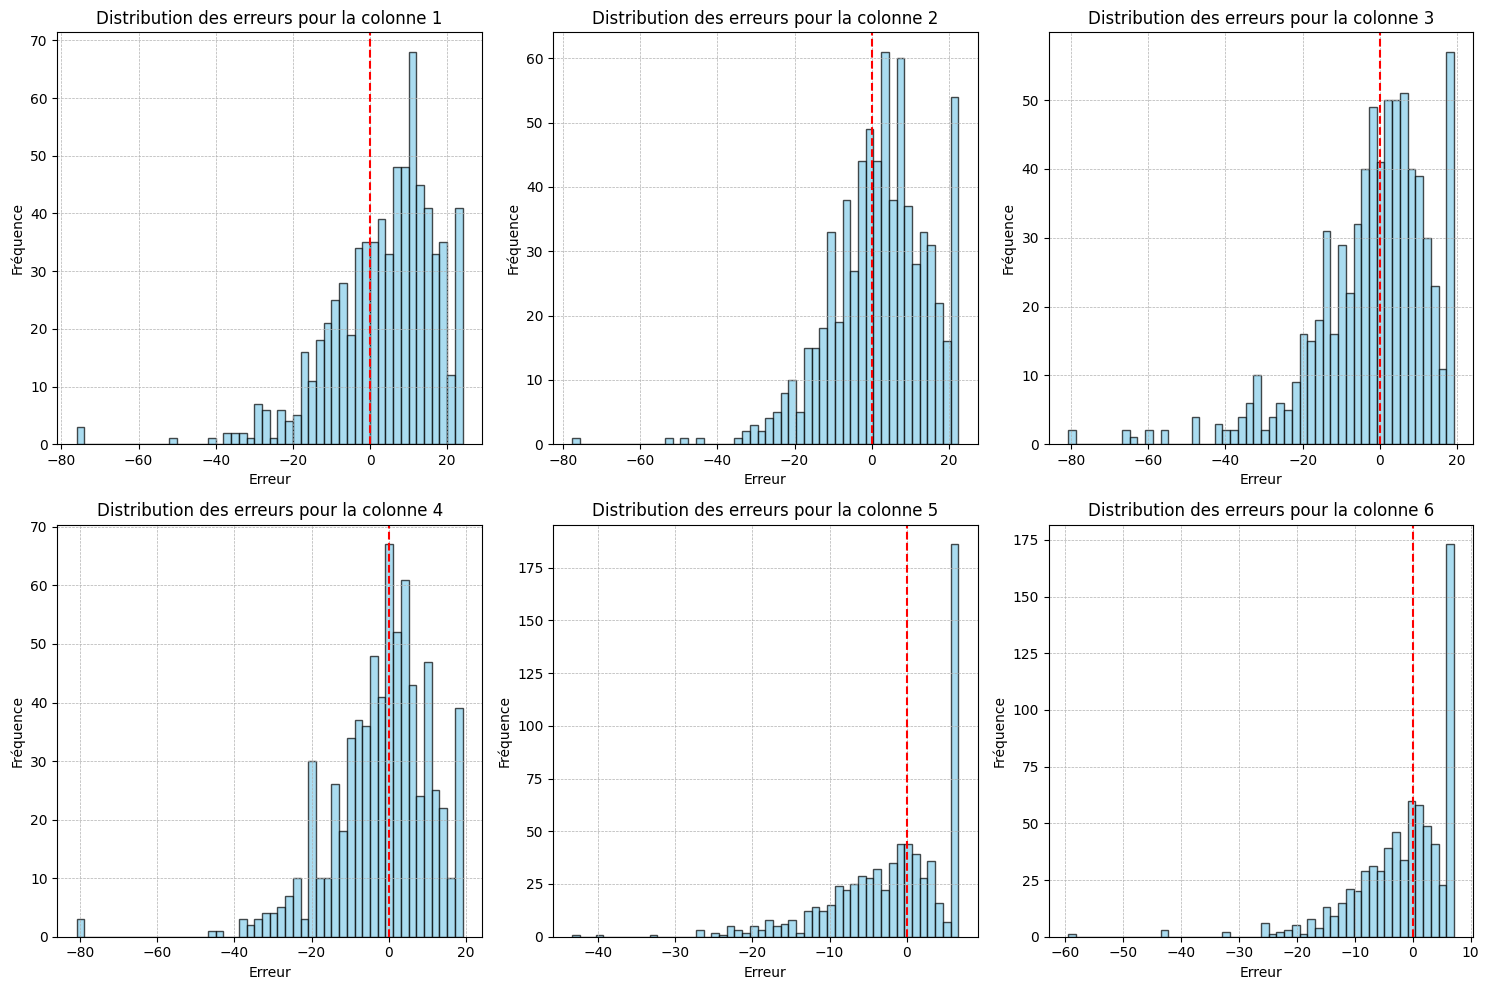

In [158]:
# Plot la distribution des erreurs pour chaque colonne
errors = y_test_pred - y_test.reset_index(drop=True)

# Identifier les colonnes contenant des NaN
nan_columns = errors.columns[errors.isnull().any()].tolist()


# Remplacer les NaN par zéro
errors.fillna(0, inplace=True)


# Création des histogrammes pour chaque colonne
n_columns = errors.shape[1]
plt.figure(figsize=(15, 10))

for i in range(n_columns):
    plt.subplot(2, 3, i+1)  # supposant que vous avez 6 colonnes, donc 2x3 sous-graphiques
    plt.hist(errors.iloc[:, i], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title(f'Distribution des erreurs pour la colonne {i + 1}')
    plt.xlabel('Erreur')
    plt.ylabel('Fréquence')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)  # ligne pour erreur = 0

plt.tight_layout()
plt.show()


La distribution des erreurs est non gaussienne. Ceci est dû au fait que la distribution des pourcentages ne l'est pas et qu'on prédit une valeur constante. 

Afin de faciliter la comparaison des performances des différents modèles, nous evaluerons la valeur moyenne des erreurs RMSE et MAE sur les 6 colonnes.

In [159]:
np.average(RMSE_mean)

11.995739100424558

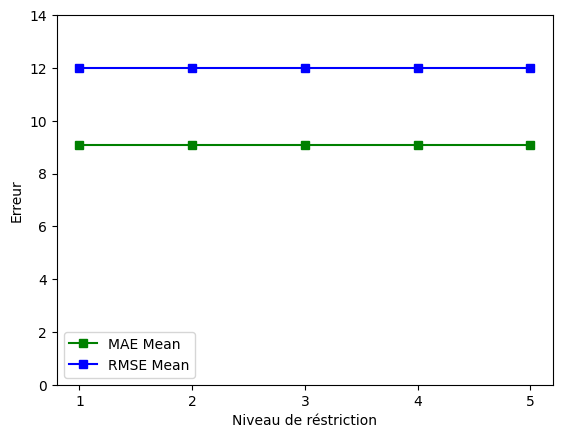

In [131]:
restriction_plot = list(range(1, 6))
plt.plot(restriction_plot, [np.average(MAE_mean)] * 5, marker='s', color='green', label='MAE Mean')
plt.plot(restriction_plot, [np.average(RMSE_mean)] * 5, marker='s', color='blue', label='RMSE Mean')


plt.xlabel("Niveau de réstriction")
plt.ylabel("Erreur")
plt.legend()
plt.xticks(restriction_plot)
plt.ylim(0, 14)

plt.show()